In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

# Data Load

In [2]:
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
path2extractedimg = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction.png'
extractedImg = cv2.imread(path2extractedimg, cv2.IMREAD_COLOR)
extractedImg = cv2.cvtColor(extractedImg, cv2.COLOR_BGR2RGB)

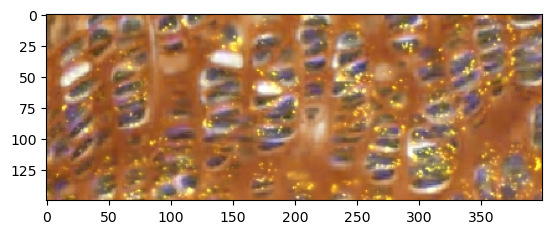

In [4]:
# possible columnar area for patch extraction
plt.imshow(image[6900:7050, 5100:5500])# [6900:7200, 6000:6700, :])
plt.show()

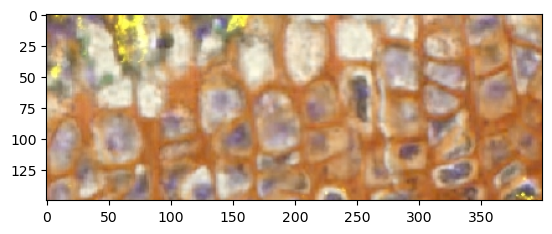

In [7]:
# possible non columnar area for patch extraction
plt.imshow(image[6700:6850, 5100:5500])#[7000:7180, 3500:4750, :])
plt.show()

# Patch Extraction

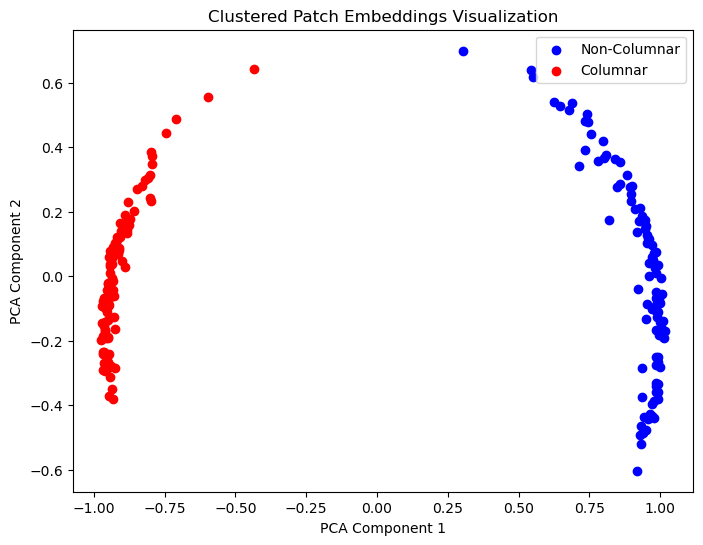

In [4]:
def set_seed(seed=42):
    random.seed(seed)                 
    np.random.seed(seed)                
    torch.manual_seed(seed)             
    torch.cuda.manual_seed(seed)        
    torch.cuda.manual_seed_all(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this function before running your experiment
set_seed(42)

columnar = image[6900:7050, 5100:5500, :]
noncolumnar = image[6700:6850, 5100:5500]# [6700:6800, 5100:5500, :]

save2 = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction'

def patch_extractor(img, num_patches=200, patch_size=64, intensity_threshold=10):
    h, w, _ = img.shape
    patches = []

    for _ in range(num_patches):
        y= np.random.randint(0, h - patch_size + 1)
        x= np.random.randint(0, w - patch_size + 1)
        patch = img[y:y+patch_size, x:x+patch_size, :]

        if np.mean(patch) > intensity_threshold :
            patches.append(patch)
    
    return np.array(patches)

num_patches = 100
patch_size = 64
columnar_patches = patch_extractor(columnar, num_patches, patch_size)
noncolumnar_patches = patch_extractor(noncolumnar, num_patches, patch_size)

all_patches = np.vstack((columnar_patches, noncolumnar_patches))
labels = np.array([1]*len(columnar_patches) + [0]*len(noncolumnar_patches)) # 1 : columnar, 0 : noncolumnar
all_patches = all_patches.astype(np.float32)/255.0

embedding_dim = 10
class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, embedding_dim)
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embedding_dim))

    def forward(self, x):
        x = self.fc(x)
        x = x / torch.norm(x, dim=1, keepdim=True)
        return x


def contrastive_loss(embeddings, labels, cluster_centers, margin=1.0):
    intra_loss = 0  
    inter_loss = 0  
    num_clusters = cluster_centers.shape[0]
    
    # Intra-cluster compactness: Pull embeddings closer to their assigned cluster center
    for i in range(num_clusters):
        cluster_embeds = embeddings[labels == i]
        if cluster_embeds.shape[0] > 1:
            intra_loss += torch.mean(1 - torch.cosine_similarity(cluster_embeds, cluster_centers[i].unsqueeze(0)))

    # Inter-cluster separation: Push clusters apart based on similarity
    num_pairs = 0
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                similarity = torch.cosine_similarity(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
                distance_penalty = torch.exp(-torch.norm(cluster_centers[i] - cluster_centers[j]))  # Exponential scaling
                inter_loss += torch.clamp(margin - similarity, min=0) * distance_penalty  # Stronger push
                num_pairs += 1

    inter_loss /= num_pairs  # Normalize
    return intra_loss + inter_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = patch_size * patch_size * 3
num_clusters = 2

model = ClusterEmbedding(input_dim, embedding_dim, num_clusters).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels, dtype=torch.long).to(device)
data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data.view(batch_data.size(0), -1))
        loss = contrastive_loss(embeddings, batch_labels, model.cluster_centers)
        loss.backward()
        optimizer.step()
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

with torch.no_grad():
    embeddings = model(data_tensor.view(data_tensor.size(0), -1)).cpu().numpy()

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Non-Columnar')
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Columnar')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustered Patch Embeddings Visualization")
plt.show()

# Apply on the whole image

In [18]:
def extract_object_patches(extracted_image_path, image_path, patch_size=64, stride=32, intensity_threshold=10, save_dir="/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction"):
    """
    Load an image, apply Otsu's thresholding, extract object-containing patches,
    and save them with their positions.
    
    Args:
        image_path (str): Path to the input image.
        patch_size (int): Size of each patch.
        stride (int): Step size for moving the patch.
        intensity_threshold (int): Minimum mean intensity to keep a patch.
        save_dir (str): Directory to save extracted patches and positions.
    
    Returns:
        filtered_patches_path (str): Path to saved filtered patches.
        filtered_positions_path (str): Path to saved patch positions.
    """
    # Load the image
    extracted_image = cv2.imread(extracted_image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(extracted_image, cv2.COLOR_BGR2GRAY)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Apply Otsu's thresholding
    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours of the object
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    object_mask = np.zeros_like(gray)
    cv2.drawContours(object_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Extract patches only from object regions
    h, w, _ = image.shape
    patches, positions = [], []
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch_mask = object_mask[y:y+patch_size, x:x+patch_size]
            if np.mean(patch_mask) > 128:  # Ensure patch contains object region
                patch = image[y:y+patch_size, x:x+patch_size, :]
                patches.append(patch)
                positions.append((y, x))

    print("# of patches : ", len(patches))
    # Convert to NumPy arrays
    patches = np.array(patches)
    positions = np.array(positions)
    
    # Filter out black patches
    print("Filtering out black patches")
    filtered_patches, filtered_positions = [], []
    for patch, position in zip(patches, positions):
        if np.mean(patch) > intensity_threshold:
            filtered_patches.append(patch)
            filtered_positions.append(position)
    
    print("# of filtered patches", len(filtered_patches))

    filtered_patches = np.array(filtered_patches)
    filtered_positions = np.array(filtered_positions)
    
    # Save results
    filtered_patches_path = os.path.join(save_dir, "filtered_patches_nb.npy")
    filtered_positions_path = os.path.join(save_dir, "filtered_patch_positions_nb.npy")
    np.save(filtered_patches_path, filtered_patches)
    np.save(filtered_positions_path, filtered_positions)
    
    
    # Visualize extracted patches
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(min(10, len(filtered_patches))):
        ax = axes[i // 5, i % 5]
        ax.imshow(cv2.cvtColor(filtered_patches[i], cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.suptitle("Filtered Patches Containing the Object")
    plt.show()
    
    print(f"Total extracted patches: {len(filtered_patches)}")
    
    return filtered_patches_path, filtered_positions_path

# of patches :  1486
Filtering out black patches
# of filtered patches 1486


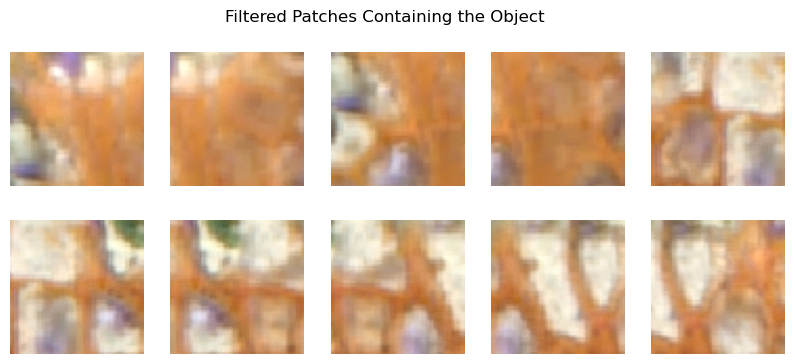

Total extracted patches: 1486


('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches_nb.npy',
 '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patch_positions_nb.npy')

In [19]:
path2extractedimg = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction.png'
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
extract_object_patches(path2extractedimg, path2img)

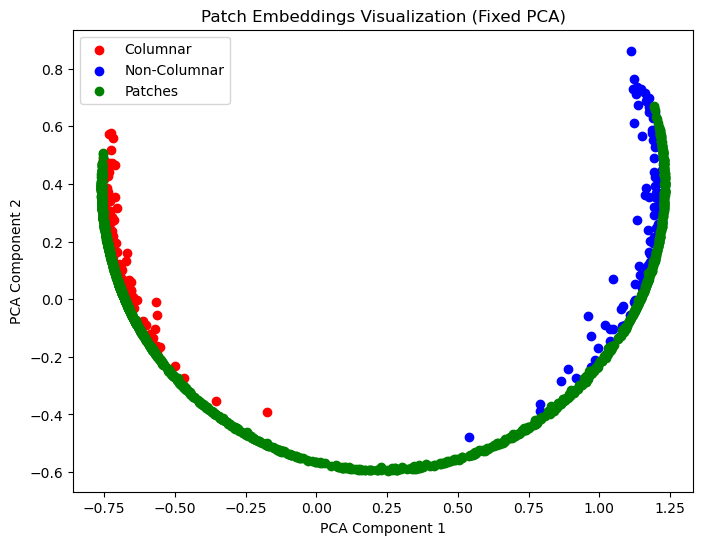

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

filtered_patches = np.load('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches_nb.npy')
data_tensor_eval = torch.tensor(filtered_patches).to(device)
data_tensor_eval = data_tensor_eval.to(torch.float32)/255.0
data_tensor_eval = data_tensor_eval.permute(0, 3, 1, 2)
data_tensor_eval = data_tensor_eval.reshape(data_tensor_eval.shape[0], -1)  

model.eval()
with torch.no_grad():
    embeddings_eval = model(data_tensor_eval).cpu().numpy()
    
# Normalize all embeddings before PCA
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings_eval = embeddings_eval / np.linalg.norm(embeddings_eval, axis=1, keepdims=True)

# Combine reference embeddings (columnar + non-columnar) and patch embeddings
all_embeddings = np.vstack((embeddings, embeddings_eval))

# Apply PCA on the combined embeddings
pca = PCA(n_components=2)
reduced_all_embeddings = pca.fit_transform(all_embeddings)

# Split back into separate groups
reduced_embeddings = reduced_all_embeddings[:len(embeddings)]  # Reference embeddings
reduced_embeddings_eval = reduced_all_embeddings[len(embeddings):]  # Patch embeddings

# Plot the updated visualization
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Columnar')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Non-Columnar')
plt.scatter(reduced_embeddings_eval[:, 0], reduced_embeddings_eval[:, 1], c='g', label='Patches')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization (Fixed PCA)")
plt.show()


In [6]:
# Build a Classifier : Logistric Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
# Train
classifier.fit(embeddings, labels) # embeddings : # * embedding_dimension, labels : #

# Test
predicted_labels = classifier.predict(embeddings_eval) # embeddings_eval : # * embedding_dimension

In [8]:
save_dir="/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction"
path2prediction = os.path.join(save_dir, "predicted_labels.npy")
np.save(path2prediction, predicted_labels)

Patch Classifier trained


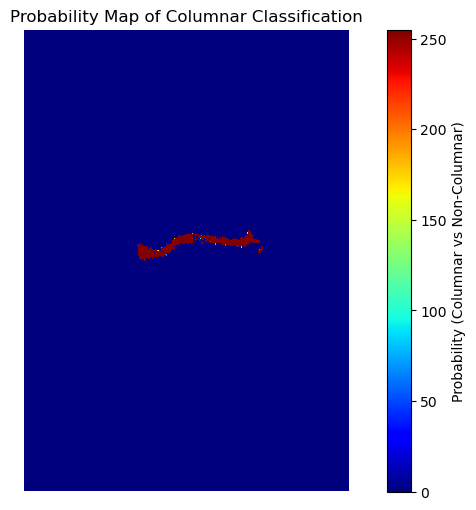

In [23]:
# Build a Classifier : Simple CNN
class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Compute final feature size dynamically
        self.flatten_size = 32 * (embedding_dim // 4)  # Adjust based on pooling layers

        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (N, 16, 10) -> (N, 16, 5)
        x = self.pool(torch.relu(self.conv2(x)))  # (N, 32, 5) -> (N, 32, 2)

        x = x.view(x.size(0), -1)  # Flatten to (N, 32*2)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

classifier = CNNClassifier(embedding_dim = 10).to(device)
criterion = nn.BCELoss()
X_train = torch.tensor(embeddings, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    # if epoch / 10 == int(epoch / 10):
    #   print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
print("Patch Classifier trained")

classifier.eval()
X_eval = torch.tensor(embeddings_eval, dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    probabilities = classifier(X_eval).cpu().numpy().squeeze()

original_image_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction.png"  # Update as needed
original_image = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
original_shape = original_image.shape[:2]  # (H, W)
filtered_positions_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patch_positions_nb.npy"
filtered_positions = np.load(filtered_positions_path)
# Generate probability map
prob_map = np.zeros(original_shape, dtype=np.float32)
patch_size = 64  # Ensure this matches the patch size used in extraction

for (y, x), prob in zip(filtered_positions, probabilities):
    prob_map[y:y+patch_size, x:x+patch_size] = prob  # Assign probability

# Normalize to [0, 255] for visualization
prob_map = (prob_map - prob_map.min()) / (prob_map.max() - prob_map.min()) * 255
prob_map = prob_map.astype(np.uint8)
Image.fromarray(prob_map).save('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/prob_map_nb.png')
plt.figure(figsize=(10, 6))
plt.imshow(prob_map, cmap="jet", interpolation="nearest")
plt.colorbar(label="Probability (Columnar vs Non-Columnar)")
plt.axis("off")
plt.title("Probability Map of Columnar Classification")
plt.show()

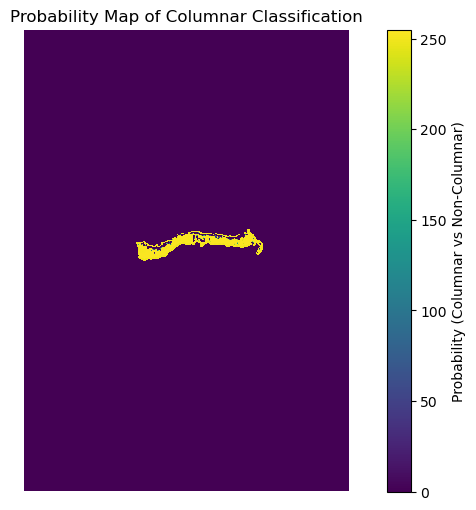

In [28]:
plt.figure(figsize=(10, 6))
plt.imshow(prob_map, interpolation="nearest")
plt.colorbar(label="Probability (Columnar vs Non-Columnar)")
plt.axis("off")
plt.title("Probability Map of Columnar Classification")
plt.show()

In [14]:
filtered_patches.shape[1]

64

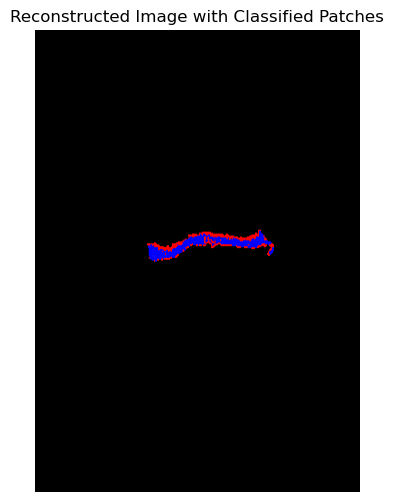

True

In [9]:
def reconstruct_image_from_patches(image_shape, patches, positions, labels):
    """
    Reconstruct an image from patches with color-coded overlay based on classification labels.

    Args:
        image_shape (tuple): The shape of the original image (H, W, C).
        patches (np.array): Array of extracted patches.
        positions (list): List of (y, x) coordinates for each patch.
        labels (np.array): Classification labels for each patch (0: non-columnar, 1: columnar).

    Returns:
        reconstructed_image (np.array): Reconstructed image with color overlay.
    """
    h, w, c = image_shape
    patch_size = patches.shape[1]
    reconstructed_image = np.zeros((h, w, c), dtype=np.uint8)
    count_map = np.zeros((h, w), dtype=np.uint8)

    # Color mapping for labels
    columnar_color = np.array([255, 0, 0], dtype=np.uint8)   # Red for columnar
    non_columnar_color = np.array([0, 0, 255], dtype=np.uint8)  # Blue for non-columnar

    # for patch, (y, x), label in zip(patches, positions, labels):
    #     color_overlay = columnar_color if label == 1 else non_columnar_color

    #     # Blend original patch with label color overlay
    #     blended_patch = (0.5 * patch + 0.5 * color_overlay).astype(np.uint8)

    #     # Assign patch to the reconstructed image
    #     reconstructed_image[y:y+patch_size, x:x+patch_size] += blended_patch
    #     count_map[y:y+patch_size, x:x+patch_size] += 1

    # # Normalize overlapping areas by averaging
    # mask = count_map > 0
    # reconstructed_image[mask] //= count_map[mask, None]

    for (y, x), label in zip(positions, labels):
        color = columnar_color if label == 1 else non_columnar_color

        # Fill patch region with the respective color
        reconstructed_image[y:y+patch_size, x:x+patch_size] = color

    return reconstructed_image

# Load the original image shape (for reconstruction)
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction.png'
original_image = cv2.imread(path2img, cv2.IMREAD_COLOR)
original_shape = original_image.shape

# Load filtered patches and positions
filtered_patches_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches_nb.npy"
filtered_positions_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patch_positions_nb.npy"

filtered_patches = np.load(filtered_patches_path)
filtered_positions = np.load(filtered_positions_path)

# Reconstruct the image with color-coded classifications
reconstructed_image = reconstruct_image_from_patches(original_shape, filtered_patches, filtered_positions, predicted_labels)

# Display the reconstructed image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Reconstructed Image with Classified Patches")
plt.show()

# Save
reconstructed_image_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/reconstructed_image_nb.png"
cv2.imwrite(reconstructed_image_path, reconstructed_image)


In [13]:
overlay_img = reconstructed_image * 0.5 + image.astype(np.float32)

# Clip values to [0, 255] and convert back to uint8
overlay_img = np.clip(overlay_img, 0, 255).astype(np.uint8)
Image.fromarray(overlay_img).save("/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/overlapimg.png")